In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import json
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import os.path
from os import path
import matplotlib.cm as cm
import warnings
from matplotlib.ticker import MultipleLocator
warnings.filterwarnings('ignore')
from time import process_time


### Import Dataset

- The dataset is over 20GB in size with ~ 101 million rows. Dataset is stored on my harddrive
- The dataset can be downloaded from https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p
- I will import 1M rows to get a feel of the data before processing the data


In [3]:
trips_raw = pd.read_csv(r'C:\WindRider\Data\TNP_Trips.csv',nrows=1000000, low_memory=False)

In [4]:
trips_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
Trip ID                       1000000 non-null object
Trip Start Timestamp          1000000 non-null object
Trip End Timestamp            1000000 non-null object
Trip Seconds                  999976 non-null float64
Trip Miles                    999965 non-null float64
Pickup Census Tract           713593 non-null float64
Dropoff Census Tract          709809 non-null float64
Pickup Community Area         939152 non-null float64
Dropoff Community Area        931265 non-null float64
Fare                          999999 non-null float64
Tip                           999999 non-null float64
Additional Charges            999999 non-null float64
Trip Total                    999999 non-null float64
Shared Trip Authorized        1000000 non-null bool
Trips Pooled                  1000000 non-null int64
Pickup Centroid Latitude      940050 non-null float64
Pickup Centroid Longitude  

In [5]:
trips_raw.head()

Trip ID    Trip Start Timestamp  \
0  fbf6b8661788fc76d5902163215a562c6c2cf577  09/19/2019 09:00:00 PM   
1  fbf6bb2a6cb7be2a12038ecc86a776aaa8aed4e2  09/23/2019 02:15:00 PM   
2  fbf6bc925f858bb52b36d0d1f555dcc40315bca3  07/14/2019 09:15:00 PM   
3  fbf6bd3746ae6f9de90af7a6de380f2658d53d49  09/07/2019 11:45:00 PM   
4  fbf6bd8a1f6bef8c53fa5b2feaff7c684634b08f  08/18/2019 03:00:00 AM   

       Trip End Timestamp  Trip Seconds  Trip Miles  Pickup Census Tract  \
0  09/19/2019 09:15:00 PM         537.0         2.7         1.703184e+10   
1  09/23/2019 03:00:00 PM        2990.0        18.2         1.703184e+10   
2  07/14/2019 09:30:00 PM        1192.0         3.0         1.703128e+10   
3  09/08/2019 12:00:00 AM        1412.0        10.3                  NaN   
4  08/18/2019 03:00:00 AM         204.0         0.5         1.703106e+10   

   Dropoff Census Tract  Pickup Community Area  Dropoff Community Area  Fare  \
0          1.703184e+10                   28.0                    24.0   7.5   
1          1.703198e+10                   32.0                    76.0  37.5   
2          1.703108e+10                   28.0                     8.0   2.5   
3                   NaN                   63.0                     8.0  17.5   
4          1.703107e+10                    6.0                     7.0   5.0   

   ...  Additional Charges  Trip Total  Shared Trip Authorized  Trips Pooled  \
0  ...                2.55       10.05                   False             1   
1  ...                8.11       45.61                   False             1   
2  ...                2.55        5.05                    True             2   
3  ...                2.55       20.05                   False             1   
4  ...                2.55        7.55                   False             1   

   Pickup Centroid Latitude  Pickup Centroid Longitude  \
0                 41.878667                 -87.671654   
1                 41.880994                 -87.632746   
2                 41.879255                 -87.642649   
3                 41.795431                 -87.696435   
4                 41.934540                 -87.643023   

               Pickup Centroid Location Dropoff Centroid Latitude  \
0  POINT (-87.6716536214 41.8786674201)                 41.898306   
1  POINT (-87.6327464887 41.8809944707)                 41.979071   
2   POINT (-87.642648998 41.8792550844)                 41.895033   
3   POINT (-87.6964352325 41.795430631)                 41.899602   
4  POINT (-87.6430228044 41.9345397158)                 41.929078   

   Dropoff Centroid Longitude             Dropoff Centroid Location  
0                  -87.653614  POINT (-87.6536139825 41.8983058696)  
1                  -87.903040  POINT (-87.9030396611 41.9790708201)  
2                  -87.619711  POINT (-87.6197106717 41.8950334495)  
3                  -87.633308   POINT (-87.6333080367 41.899602111)  
4                  -87.646293  POINT (-87.6462934762 41.9290776551)  

[5 rows x 21 columns]

(0, 60)

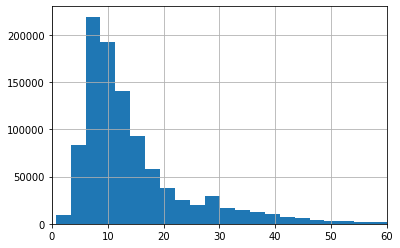

In [6]:
trips_raw['Trip Total'].hist(bins=200)
plt.xlim(0,60)

(0, 3600)

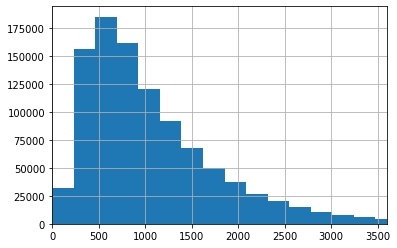

In [7]:
trips_raw['Trip Seconds'].hist(bins=200)
plt.xlim(0,3600)

(0, 25)

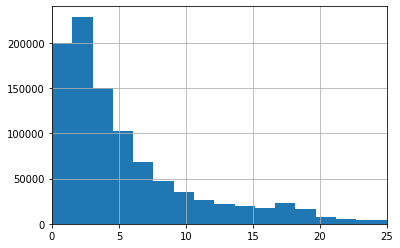

In [8]:
trips_raw['Trip Miles'].hist(bins=200)
plt.xlim(0,25)

(0, 25)

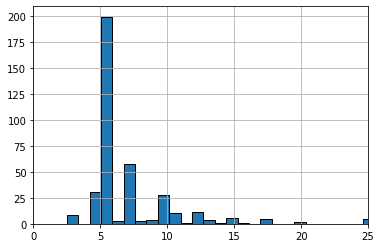

In [12]:
(trips_raw.loc[trips_raw['Trip Miles'] == 0, 'Trip Total']).hist(bins=50,edgecolor='black')
plt.xlim([0,25])

In [13]:
trips_raw.loc[trips_raw['Trip Seconds']>7200].count()

Trip ID                       208
Trip Start Timestamp          208
Trip End Timestamp            208
Trip Seconds                  208
Trip Miles                    208
Pickup Census Tract           143
Dropoff Census Tract           75
Pickup Community Area         162
Dropoff Community Area         95
Fare                          208
Tip                           208
Additional Charges            208
Trip Total                    208
Shared Trip Authorized        208
Trips Pooled                  208
Pickup Centroid Latitude      165
Pickup Centroid Longitude     165
Pickup Centroid Location      165
Dropoff Centroid Latitude      96
Dropoff Centroid Longitude     96
Dropoff Centroid Location      96
dtype: int64

### From the initial review of data we can see

- Most trips are shorter distance (< 4 miles) and cost between \\$5 to \\$15
- There are a  trips with 0 miles logged having $5 charge (possibly cancellation charge). Need to be removed!
- Some data with very long trip times (> 2 hours) that may not be useful for the model to predict major rides(within the city)
- I will further clean the dataset and use 25% of overall data

In [2]:
# Parse all the timestamped data, remove anomalies in data
def parse_timestamp(df):
    
    df['Start Time'] = pd.to_datetime(df['Trip Start Timestamp'])
    df['End Time'] = pd.to_datetime(df['Trip End Timestamp']) 
    df['Year'] = df['Start Time'].dt.year
    df['PU_Hour'] = df['Start Time'].dt.hour
    df['DO_Hour'] = df['End Time'].dt.hour
    
    # Remove all rows with > 2 hr trip time and 0s
    df = df.loc[df['Trip Seconds']<7200]
    df = df.loc[df['Trip Seconds']!=0]
    
    df['Month'] = df['Start Time'].dt.strftime('%B')
    df['Day'] = df['Start Time'].dt.strftime('%A')
    df['Trip_Time'] = df['Trip Seconds']/60
    
    return df

In [3]:
# Remove all rows with 0 Miles and $0 Charge 
def filter_df(df):
    df = df.loc[df['Trip Total']!=0]
    df = df.loc[df['Trip Miles']!=0]
    df = df.loc[(df['Trip Miles']>0.25) & (df['Trip Total'] >5)]
    return df

In [4]:
# Add pickup and dropoff census tract frequency
def add_CT_freq(df):
    df1 = df['Pickup Census Tract'].value_counts().reset_index(name='Pickup_CT_Freq').rename(columns={'index': 'Pickup Census Tract'})
    df2 = df['Dropoff Census Tract'].value_counts().reset_index(name='Dropoff_CT_Freq').rename(columns={'index': 'Dropoff Census Tract'})

    df = pd.merge(df,df1,on=['Pickup Census Tract'], how='left' )
    df = pd.merge(df,df2,on=['Dropoff Census Tract'], how='left' )
    return df

In [5]:
# Calculating Distance from City Center (CC)
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = 3958.8 * c
    return distance

In [6]:
# Divide the dataset in chunks and process each chunk before concatenating into a dataframe
def chunk_preprocessing(chunk):
    
    chunk=chunk.drop(columns = ['Trip ID', 'Pickup Centroid Location', 'Dropoff Centroid Location' ])
    chunk = parse_timestamp(chunk)

    chunk = chunk.rename(columns={"Pickup Centroid Latitude": "PU_lat", "Pickup Centroid Longitude": "PU_long",
                             "Dropoff Centroid Latitude": "DO_lat", "Dropoff Centroid Longitude": "DO_long"})
    
    chunk = filter_df(chunk)
    chunk = chunk.drop(columns = ['Tip', 'Fare', 'Additional Charges', 'Trip Seconds', 
                                        'Start Time', 'End Time','Trip Start Timestamp','Trip End Timestamp'])
    
    chunk = chunk.dropna(subset = ['Trip Miles', 'Trip Total','PU_lat', 'DO_lat',
                                         'Pickup Census Tract','Dropoff Census Tract' ,
                                         'Pickup Community Area','Dropoff Community Area'])
    
    # Calculate distance from City Center (Downtown)
    chunk['PU_Dist_CC'] = haversine_np(41.8781, -87.6298,chunk['PU_lat'],chunk['PU_long'])
    chunk['DO_Dist_CC'] = haversine_np(41.8781, -87.6298,chunk['DO_lat'],chunk['DO_long'])
    chunk['Pickup Census Tract'] = chunk['Pickup Census Tract'].astype(float)
    chunk['Dropoff Census Tract'] = chunk['Dropoff Census Tract'].astype(float)

    return chunk

In [7]:
# Github has a file size limit of 100mb, hence I have stored the pickled dataset locally. 
# I have uploaded the smaller pickled chunks and they can be appended to form the dataset

fpath = "C:/WindRider/Pickled Data/trips_25percent.pkl"
if path.exists(fpath):
    trips = pd.read_pickle(fpath)
else:
    chunk_size, skip_size = 250000 , 1000000
    trips = pd.DataFrame() 
    tic = process_time()
    for n in range(201):

        dpath ='./Pickled Data/'
        os.makedirs(dpath, exist_ok=True) 
        fname = dpath + 'trips_part_'+ str(n)+ '.pkl'
        if os.path.exists(fname):
            chunk_filter = pd.read_pickle(fname)
        else:
            chunk = pd.read_csv('c:/Machine Learning/TNP_Trips.csv',skiprows=np.arange(1, (n+1)*skip_size),
                                nrows=chunk_size, low_memory=False) 

            chunk_filter = chunk_preprocessing(chunk)

        trips = trips.append(chunk_filter,sort = False,ignore_index=True)
        chunk_filter.to_pickle(fname)
        if n%10==0:
            toc = process_time()

            print("Processed chunk #",n, 'of',200 , 'Time taken = ', int(toc-tic), 'seconds' )

    trips.to_pickle("./Pickled Data/trips_25percent.pkl")

trips = trips.reset_index(drop=True)
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810055 entries, 0 to 16810054
Data columns (total 20 columns):
Trip Miles                float64
Pickup Census Tract       float64
Dropoff Census Tract      float64
Pickup Community Area     float64
Dropoff Community Area    float64
Trip Total                float64
Shared Trip Authorized    object
Trips Pooled              object
PU_lat                    float64
PU_long                   float64
DO_lat                    float64
DO_long                   float64
Year                      int64
PU_Hour                   int64
DO_Hour                   int64
Month                     object
Day                       object
Trip_Time                 float64
PU_Dist_CC                float64
DO_Dist_CC                float64
dtypes: float64(13), int64(3), object(4)
memory usage: 2.5+ GB


In [8]:
trips.head()

Trip Miles  Pickup Census Tract  Dropoff Census Tract  \
0         1.7         1.703103e+10          1.703101e+10   
1         1.2         1.703132e+10          1.703108e+10   
2         3.2         1.703183e+10          1.703183e+10   
3        10.9         1.703131e+10          1.703106e+10   
4         2.3         1.703124e+10          1.703108e+10   

   Pickup Community Area  Dropoff Community Area  Trip Total  \
0                   77.0                     1.0        7.55   
1                   32.0                     8.0        7.55   
2                   22.0                    21.0        5.05   
3                   31.0                     6.0       18.22   
4                   24.0                     8.0        9.55   

  Shared Trip Authorized Trips Pooled     PU_lat    PU_long     DO_lat  \
0                  False            1  41.987226 -87.664938  42.009413   
1                  False            1  41.884987 -87.620993  41.892508   
2                   True            3  41.919225 -87.671446  41.942859   
3                   True            1  41.856333 -87.659564  41.942692   
4                  False            1  41.892355 -87.674507  41.893216   

     DO_long  Year  PU_Hour  DO_Hour     Month       Day  Trip_Time  \
0 -87.663958  2019       21       21     March   Tuesday   7.933333   
1 -87.626215  2019       21       21  February    Friday   6.833333   
2 -87.717504  2019        9        9     March   Tuesday   7.466667   
3 -87.651771  2019       17       17  February    Sunday  26.000000   
4 -87.637844  2019       10       10  February  Thursday  10.466667   

   PU_Dist_CC  DO_Dist_CC  
0    2.447458    2.389347  
1    0.608837    0.251112  
2    2.879833    6.062539  
3    2.057462    1.529108  
4    3.089239    0.557478

In [9]:
trips['Rate_Dist'] = trips['Trip Total']/trips['Trip Miles']
trips['Rate_Time'] = (trips['Trip Total'])/trips['Trip_Time']

In [10]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'black', "grid.linewidth": 2, 'lines.markersize':20})

## Trip Cost (\\$/mile) and Total Trips Monthly Summary

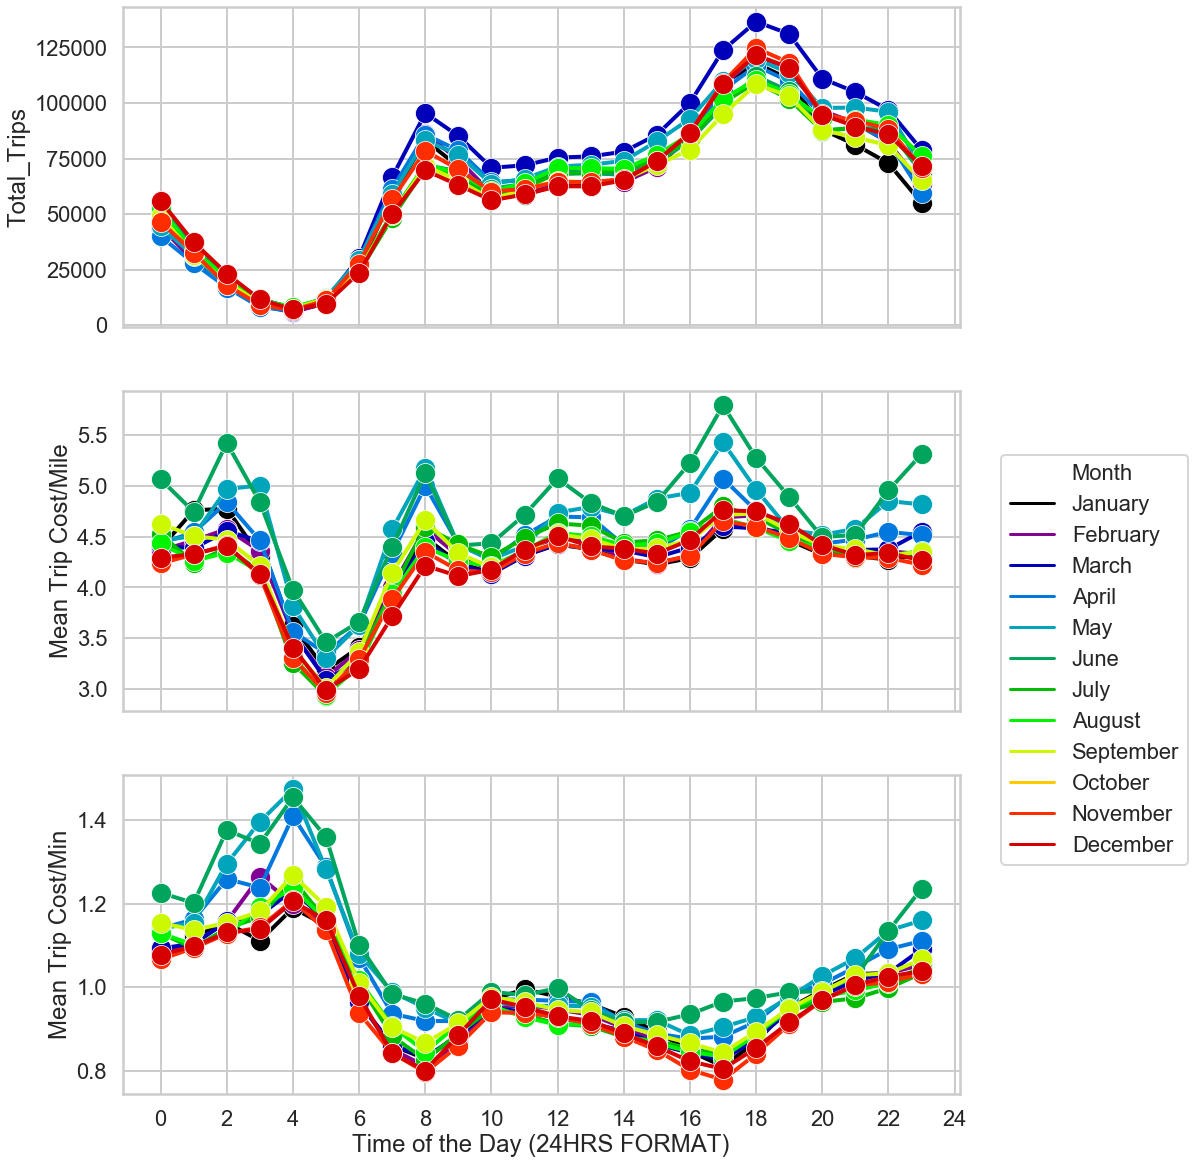

In [18]:
trips_cost_month=trips.groupby(['Month', 'PU_Hour'])['Rate_Dist'].agg(['mean']).sort_values(['mean'], ascending=False)
trips_cost_month['Total_Trips'] = trips.groupby(['Month', 'PU_Hour'])['Trip Total'].agg(['count'])
trips_cost_month['Mean Trip Cost/Min'] = trips.groupby(['Month', 'PU_Hour'])['Rate_Time'].agg(['mean'])
trips_cost_month = trips_cost_month.rename(columns={'mean': 'Mean Trip Cost/Mile'})
trips_cost_month['Avg Trip Distance']=trips.groupby(['Month', 'PU_Hour'])['Trip Miles'].agg(['mean']).sort_values(['mean'])
trips_cost_month = trips_cost_month.reset_index()
cat_month = ['January', 'February', 'March', 'April','May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
trips_cost_month['Month'] = pd.Categorical(trips_cost_month['Month'], ordered=True, categories=cat_month)

colors = cm.nipy_spectral(np.linspace(0, 1, trips_cost_month['Month'].nunique()+2))
fig, ax = plt.subplots(3,figsize=(15,20), sharex=True)

plot_1 = sns.lineplot(x="PU_Hour", y="Total_Trips",palette=colors, hue="Month",linewidth=4,
                  data=trips_cost_month, ax=ax[0],marker='o',legend=False)
plot_2 = sns.lineplot(x="PU_Hour", y="Mean Trip Cost/Mile",hue="Month",linewidth=4,palette=colors ,
                  data=trips_cost_month,marker='o', ax= ax[1],legend=False);
plot_3 = sns.lineplot(x="PU_Hour", y="Mean Trip Cost/Min",hue="Month",linewidth=4,palette=colors ,
                  data=trips_cost_month,marker='o', ax= ax[2]);
plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 2), loc=2, borderaxespad=0.)
plot_2.xaxis.set_major_locator(MultipleLocator(2))
fig.savefig('./Images/Trips_Month_Summary.png',bbox_inches='tight')

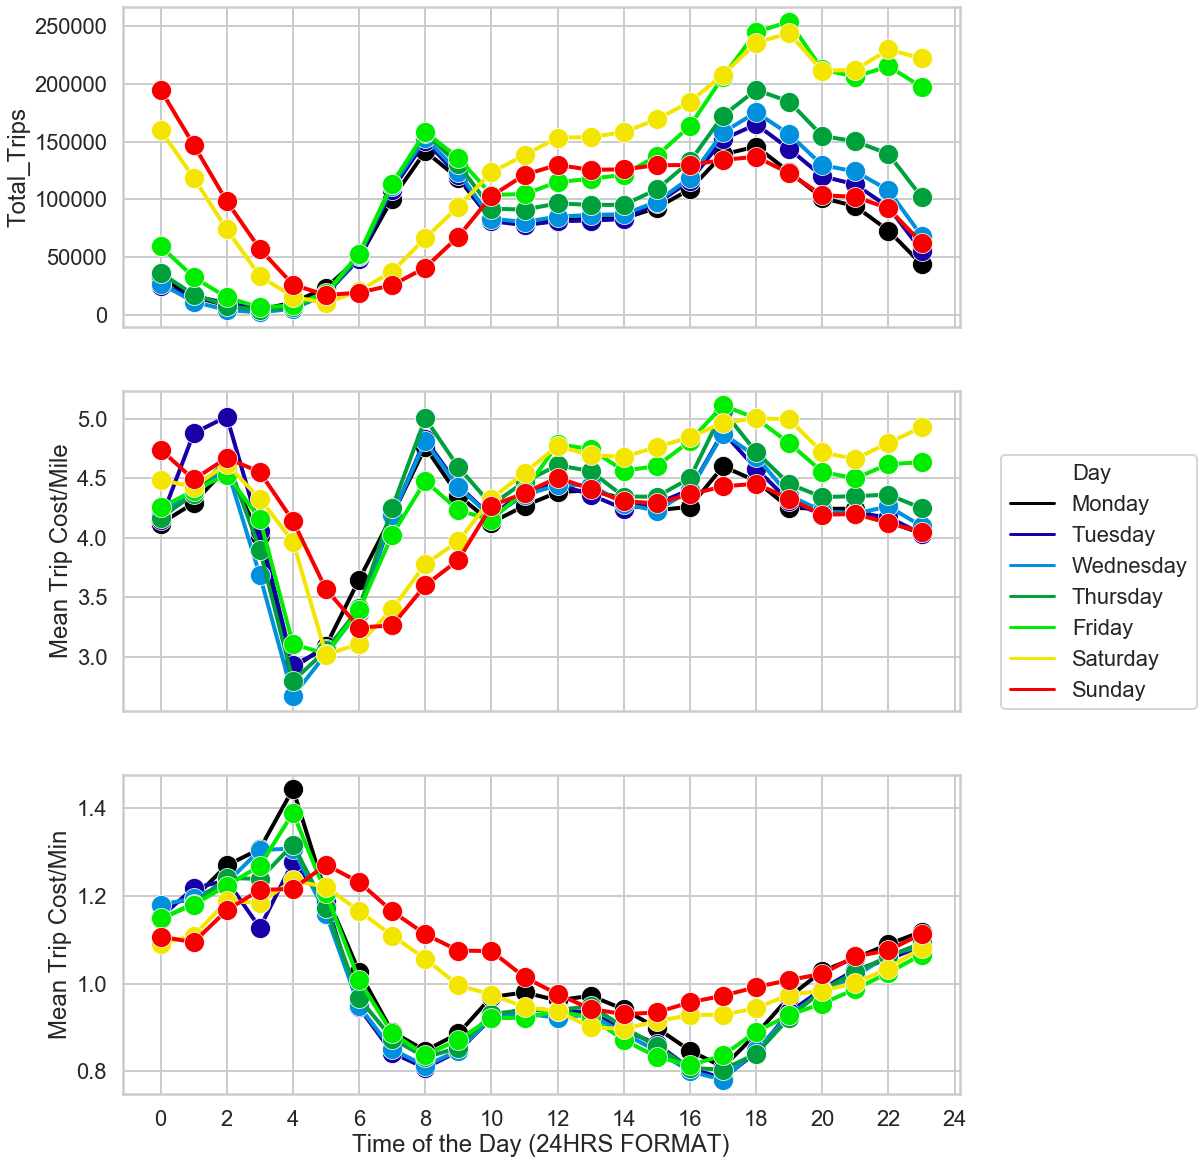

In [22]:
trips_cost_day=trips.groupby(['Day', 'PU_Hour'])['Rate_Dist'].agg(['mean']).sort_values(['mean'], ascending=False)
trips_cost_day['Total_Trips'] = trips.groupby(['Day', 'PU_Hour'])['Trip Total'].agg(['count']).sort_values(['count'])
trips_cost_day['Mean Trip Cost/Min'] = trips.groupby(['Day', 'PU_Hour'])['Rate_Time'].agg(['mean'])

trips_cost_day = trips_cost_day.rename(columns={'mean': 'Mean Trip Cost/Mile'})
trips_cost_day['Avg Trip Distance']=trips.groupby(['Day', 'PU_Hour'])['Trip Miles'].agg(['mean']).sort_values(['mean'])
trips_cost_day = trips_cost_day.reset_index()

cat_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
trips_cost_day['Day'] = pd.Categorical(trips_cost_day['Day'], ordered=True, categories=cat_day)

colors = cm.nipy_spectral(np.linspace(0, 1, trips_cost_day['Day'].nunique()+1))
fig, ax = plt.subplots(3,figsize=(15,20), sharex=True)

plot_1 = sns.lineplot(x="PU_Hour", y="Total_Trips",palette=colors, hue="Day",linewidth=4,
                  data=trips_cost_day, ax=ax[0], marker='o', legend=False)
plot_2 = sns.lineplot(x="PU_Hour", y="Mean Trip Cost/Mile",hue="Day",linewidth=4,palette=colors ,
                  data=trips_cost_day,marker='o', ax= ax[1], legend=False);
plot_3 = sns.lineplot(x="PU_Hour", y="Mean Trip Cost/Min",hue="Day",linewidth=4,palette=colors ,
                  data=trips_cost_day,marker='o', ax= ax[2]);
plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 2), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))
fig.savefig('./Images/Trips_Week_Summary.png',bbox_inches='tight')

In [26]:
trips_trunc=trips.sample(frac=0.05)
trips_trunc = trips_trunc.loc[trips_trunc['Trip Miles']>1]
trips_trunc = trips_trunc.loc[trips_trunc['Trip Miles']<50]
trips_trunc['Month'] = pd.Categorical(trips_trunc['Month'], ordered=True, categories=cat_month)
trips_trunc['Day'] = pd.Categorical(trips_trunc['Day'], ordered=True, categories=cat_day)

In [34]:
trips.groupby(['Month', 'Shared Trip Authorized'])['Rate_Dist'].agg(['sum'])

sum
Month     Shared Trip Authorized              
April     False                   6.106583e+06
          True                    8.196642e+05
August    False                   6.154030e+06
          True                    5.004282e+05
December  False                   5.715293e+06
          True                    8.592639e+05
February  False                   5.692352e+06
          True                    9.343614e+05
January   False                   5.439044e+06
          True                    9.434193e+05
July      False                   5.995434e+06
          True                    5.287630e+05
June      False                   6.680390e+06
          True                    6.308423e+05
March     False                   6.686582e+06
          True                    9.896033e+05
May       False                   6.779091e+06
          True                    7.750674e+05
November  False                   5.699070e+06
          True                    9.062729e+05
September False                   5.864763e+06
          True                    4.600370e+05

In [37]:
trips.groupby(['Month']).agg(['count'])

Trip Miles Pickup Census Tract Dropoff Census Tract  \
               count               count                count   
Month                                                           
April        1520967             1520967              1520967   
August       1521295             1521295              1521295   
December     1504954             1504954              1504954   
February     1509063             1509063              1509063   
January      1468379             1468379              1468379   
July         1470235             1470235              1470235   
June         1495256             1495256              1495256   
March        1757769             1757769              1757769   
May          1600219             1600219              1600219   
November     1532804             1532804              1532804   
September    1429114             1429114              1429114   

          Pickup Community Area Dropoff Community Area Trip Total  \
                          count                  count      count   
Month                                                               
April                   1520967                1520967    1520967   
August                  1521295                1521295    1521295   
December                1504954                1504954    1504954   
February                1509063                1509063    1509063   
January                 1468379                1468379    1468379   
July                    1470235                1470235    1470235   
June                    1495256                1495256    1495256   
March                   1757769                1757769    1757769   
May                     1600219                1600219    1600219   
November                1532804                1532804    1532804   
September               1429114                1429114    1429114   

          Shared Trip Authorized Trips Pooled   PU_lat  PU_long  ...  DO_long  \
                           count        count    count    count  ...    count   
Month                                                            ...            
April                    1520967      1520967  1520967  1520967  ...  1520967   
August                   1521295      1521295  1521295  1521295  ...  1521295   
December                 1504954      1504954  1504954  1504954  ...  1504954   
February                 1509063      1509063  1509063  1509063  ...  1509063   
January                  1468379      1468379  1468379  1468379  ...  1468379   
July                     1470235      1470235  1470235  1470235  ...  1470235   
June                     1495256      1495256  1495256  1495256  ...  1495256   
March                    1757769      1757769  1757769  1757769  ...  1757769   
May                      1600219      1600219  1600219  1600219  ...  1600219   
November                 1532804      1532804  1532804  1532804  ...  1532804   
September                1429114      1429114  1429114  1429114  ...  1429114   

              Year  PU_Hour  DO_Hour      Day Trip_Time PU_Dist_CC DO_Dist_CC  \
             count    count    count    count     count      count      count   
Month                                                                           
April      1520967  1520967  1520967  1520967   1520967    1520967    1520967   
August     1521295  1521295  1521295  1521295   1521295    1521295    1521295   
December   1504954  1504954  1504954  1504954   1504954    1504954    1504954   
February   1509063  1509063  1509063  1509063   1509063    1509063    1509063   
January    1468379  1468379  1468379  1468379   1468379    1468379    1468379   
July       1470235  1470235  1470235  1470235   1470235    1470235    1470235   
June       1495256  1495256  1495256  1495256   1495256    1495256    1495256   
March      1757769  1757769  1757769  1757769   1757769    1757769    1757769   
May        1600219  1600219  1600219  1600219   1600219    1600219    1600219   
November   1532804  15328

In [40]:
trips['Trips Pooled'].value_counts()

1     14462706
2      1098500
3       899980
4       215356
5        78675
6        32156
7        13274
8         5547
9         2194
10         954
11         397
12         180
13          77
14          28
15          13
16          11
20           3
24           3
17           1
Name: Trips Pooled, dtype: int64

In [39]:
trips.groupby(['Day', 'Shared Trip Authorized'])['Rate_Dist'].agg(['count'])


count
Day       Shared Trip Authorized         
Friday    False                   2458929
          True                     542615
Monday    False                   1450451
          True                     384582
Saturday  False                   2782496
          True                     491894
Sunday    False                   1904923
          True                     407853
Thursday  False                   1906957
          True                     445201
Tuesday   False                   1541648
          True                     427441
Wednesday False                   1642935
          True                     422130

In [38]:
trips.groupby(['Month', 'Shared Trip Authorized'])['Rate_Dist'].agg(['count'])


count
Month     Shared Trip Authorized         
April     False                   1213004
          True                     307963
August    False                   1337676
          True                     183619
December  False                   1177145
          True                     327809
February  False                   1158576
          True                     350487
January   False                   1116782
          True                     351597
July      False                   1277099
          True                     193136
June      False                   1269655
          True                     225601
March     False                   1376949
          True                     380820
May       False                   1314449
          True                     285770
November  False                   1182689
          True                     350115
September False                   1264315
          True                     164799

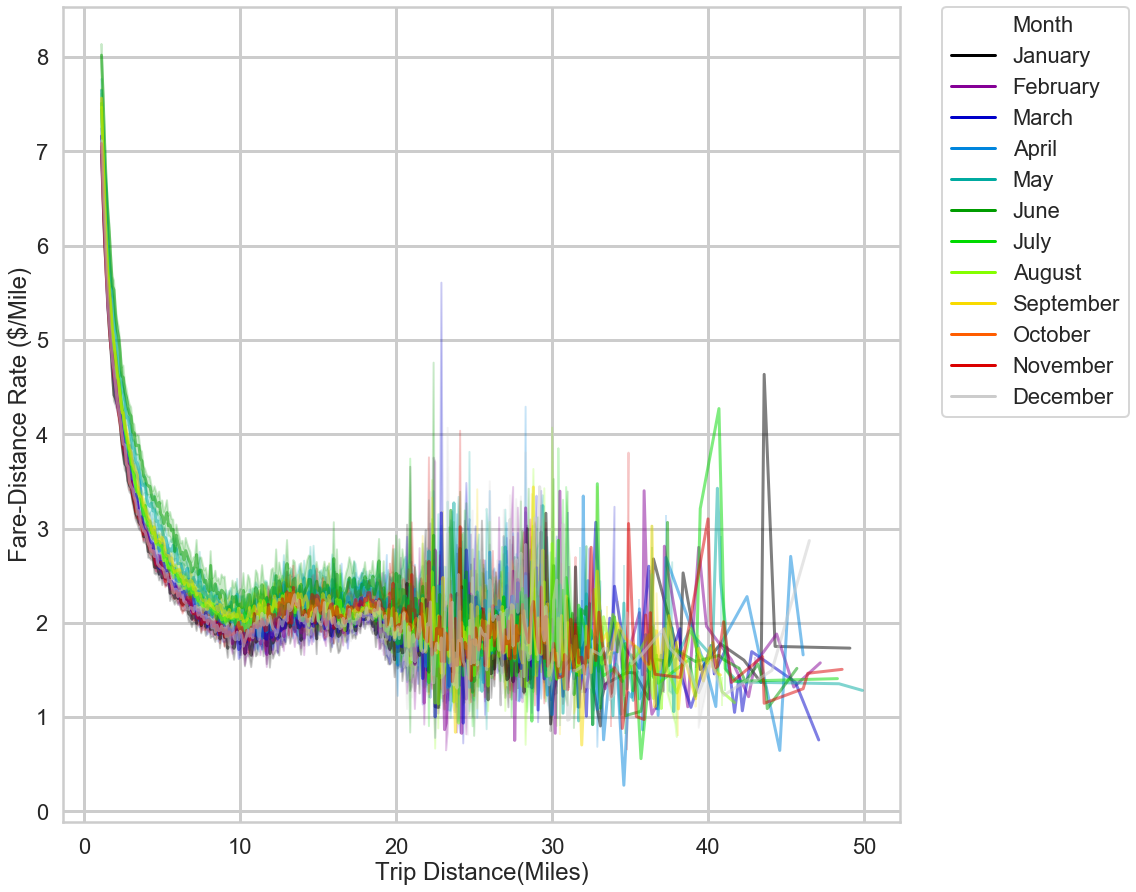

In [27]:
fig = plt.figure(figsize=(15,15))
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'white', "grid.linewidth": 3})
colors = cm.nipy_spectral(np.linspace(0, 1, trips_trunc['Month'].nunique()+1))
ax = sns.lineplot(x="Trip Miles", y="Rate_Dist",hue="Month",alpha=0.5, linewidth=3, palette=colors , data=trips_trunc)
plt.xlabel(xlabel = 'Trip Distance(Miles)')
plt.ylabel(ylabel = 'Fare-Distance Rate ($/Mile)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

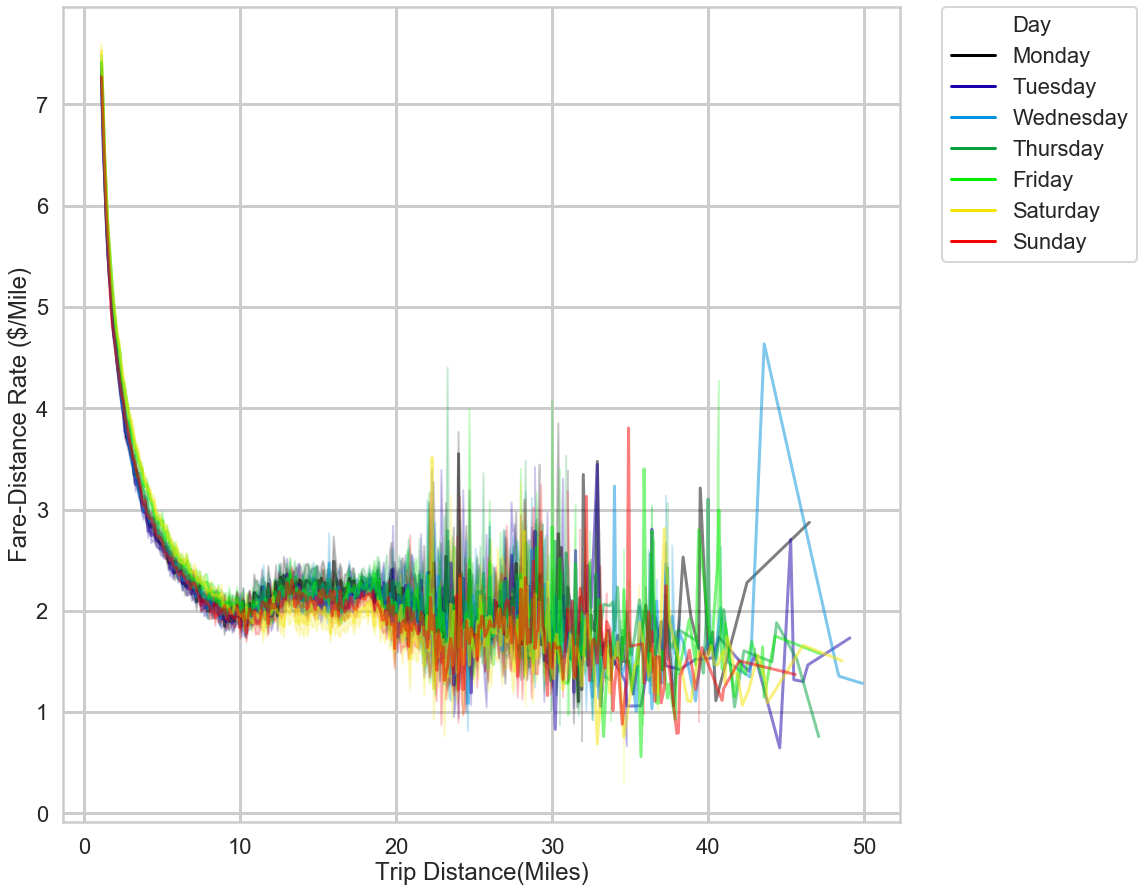

In [30]:
fig = plt.figure(figsize=(15,15))
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'white', "grid.linewidth": 3})
colors = cm.nipy_spectral(np.linspace(0, 1, trips_trunc['Day'].nunique()+1))

ax = sns.lineplot(x="Trip Miles", y="Rate_Dist",hue="Day",alpha=0.5, linewidth=3, palette= colors, data=trips_trunc)
plt.xlabel(xlabel = 'Trip Distance(Miles)')
plt.ylabel(ylabel = 'Fare-Distance Rate ($/Mile)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [28]:
sns.set_context("poster", rc={'grid.color': 'black', "grid.linewidth": 2, 'lines.markersize':15})

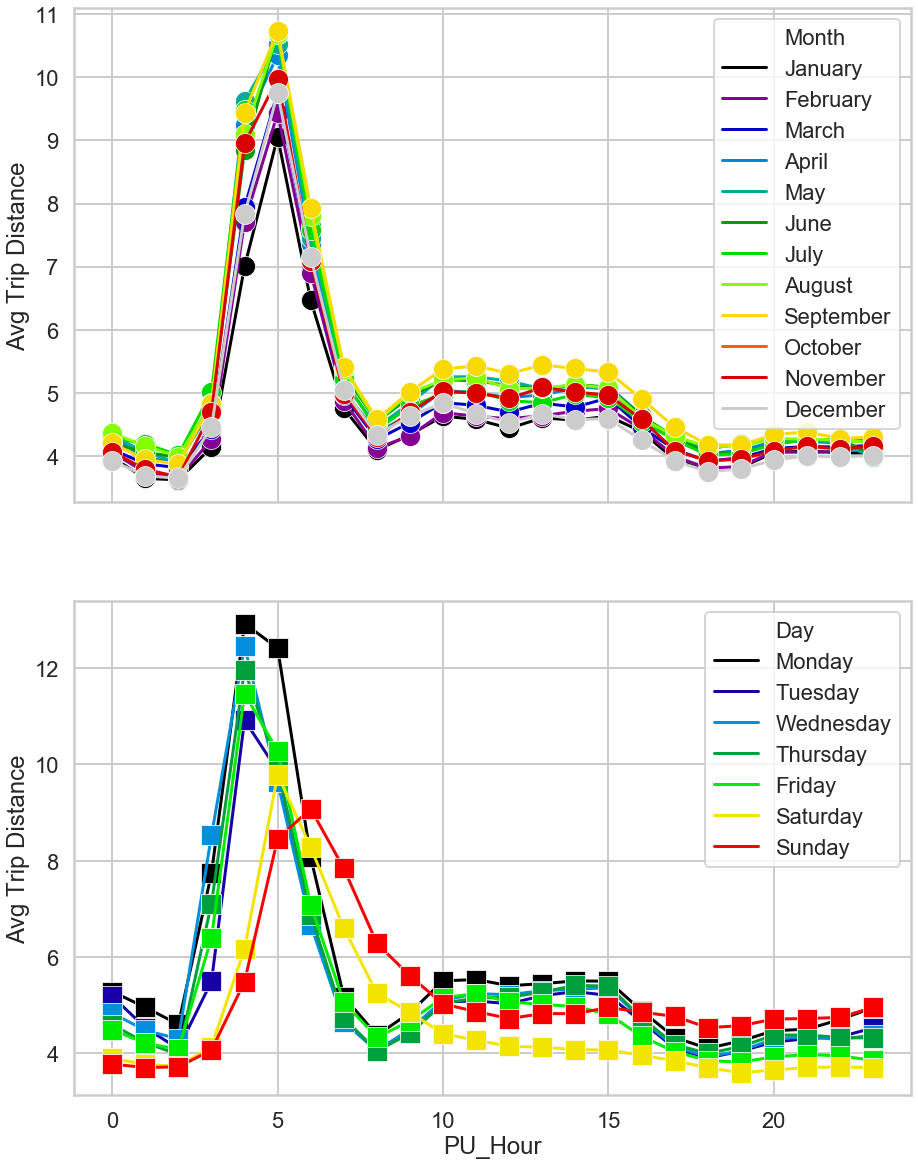

In [18]:
colors_month = cm.nipy_spectral(np.linspace(0, 1, trips_cost_month['Month'].nunique()+1))
colors_day = cm.nipy_spectral(np.linspace(0, 1, trips_cost_day['Day'].nunique()+1))

fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

plot_1 = sns.lineplot(x="PU_Hour", y="Avg Trip Distance",hue="Month",linewidth=3, palette=colors_month, 
                      data=trips_cost_month,ax=ax[0], marker='o')

plot_2 = sns.lineplot(x="PU_Hour", y="Avg Trip Distance",hue="Day",linewidth=3, palette=colors_day, 
                      data=trips_cost_day,ax=ax[1],marker='s')
fig.savefig('./Images/Trip_Distance_Summary.png',bbox_inches='tight')

In [19]:
chic_coor = [41.8781, -87.6298]

def generateBaseMap(default_location=chic_coor, default_zoom_start=8.5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [20]:
top5_pickup = trips.groupby(['PU_lat','PU_long'])['Trip Total'].agg(['count']).sort_values(['count'],ascending=False).head(5)

base_map = generateBaseMap(default_zoom_start=11)
for lat,long in top5_pickup.index:
    folium.Marker([lat,long], popup='<i>Chicago City Center</i>').add_to(base_map)
base_map.save('./HTML/Top5_pickup_locations.html')
base_map

In [21]:
top5_dropoff = trips.groupby(['DO_lat', 'DO_long'])['Trip Total'].agg(['count']).sort_values(['count'], ascending=False).head(5)

base_map = generateBaseMap(default_zoom_start=11)
for lat,long in top5_dropoff.index:
    folium.Marker([lat,long], popup='<i>Chicago City Center</i>').add_to(base_map)
base_map.save('./HTML/Top5_dropoff_locations.html')
base_map

In [22]:
def get_bearing(p1, p2):
    
    ''' 
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

In [23]:
from collections import namedtuple
def get_arrows(locations, color='blue', size=6, n_arrows=3):
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    rotation = get_bearing(p1, p2) - 90
    
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [24]:
top5_trips = trips.groupby(['PU_lat','PU_long','DO_lat', 'DO_long']) \
            ['Trip Total'].agg(['count']).sort_values(['count'], ascending=False).head(5)
base_map = generateBaseMap(default_zoom_start=11)
colors = ['blue', 'yellow', 'green', 'black','cyan' ]
count=0
for lat1,lon1,lat2,lon2 in top5_trips.index:
    loc1 = (lat1,lon1)
    loc2 = (lat2,lon2)
    folium.Marker(location=loc1,icon=folium.Icon(color='green')).add_to(base_map)
    folium.Marker(location=loc2, icon=folium.Icon(color='red')).add_to(base_map)
    
    folium.PolyLine(locations=[loc1, loc2],popup=count, color=colors[count]).add_to(base_map)
    arrows = get_arrows(locations=[loc1, loc2], n_arrows=3)
    for arrow in arrows:
        arrow.add_to(base_map)
    count+=1
base_map.save('./HTML/Top5_Trips.html')
base_map

In [25]:
trips['count'] = 1
base_map = generateBaseMap(default_zoom_start=11)
HeatMap(data=trips[['PU_lat', 'PU_long', 'count']].groupby(['PU_lat', 'PU_long']).sum().reset_index().values.tolist(),
        radius=10, max_zoom=6).add_to(base_map)
base_map.save('./HTML/Pickup_HeatMap.html')
base_map

In [26]:
base_map = generateBaseMap(default_zoom_start=11)
HeatMap(data=trips[['DO_lat', 'DO_long', 'count']].groupby(['DO_lat', 'DO_long']).sum().reset_index().values.tolist(),
        radius=10, max_zoom=1).add_to(base_map)
base_map.save('./HTML/Dropoff_HeatMap.html')
base_map

In [27]:
trip_PU_Hour_list = []
for PU_Hour in trips.PU_Hour.sort_values().unique():
    trip_PU_Hour_list.append(trips.loc[trips.PU_Hour == PU_Hour,
                            ['PU_lat', 'PU_long', 'count']].groupby(['PU_lat', 'PU_long']).sum().reset_index().values.tolist())

In [28]:
trip_DO_Hour_list = []
for DO_Hour in trips.PU_Hour.sort_values().unique():
    trip_DO_Hour_list.append(trips.loc[trips.DO_Hour == DO_Hour,
                            ['DO_lat', 'DO_long', 'count']].groupby(['DO_lat', 'DO_long']).sum().reset_index().values.tolist())

In [95]:
base_map = generateBaseMap(default_zoom_start=11)
import branca
colormap = cm.LinearColormap(colors=['blue','cyan', 'yellow','orange','red'],vmin=0,vmax=1)
colormap = colormap.to_step(index=[0,0.1, 0.25, 0.5, 0.75, 1.0])
colormap.caption = 'Ratio of Trips'
colormap.add_to(base_map)
index = trips['PU_Hour'].sort_values().unique().tolist()

HeatMapWithTime(trip_PU_Hour_list, radius=15, 
                gradient={0.1: 'blue', 0.25: 'cyan', 0.5: 'yellow', 0.75: 'orange', 1: 'red'}, 
                min_opacity=0.3, max_opacity=0.95, use_local_extrema=True,
                min_speed =1,speed_step=1, index=index).add_to(base_map)
folium.Marker([41.8781,- 87.6298], popup='<i>Chicago City Center</i>').add_to(base_map)
#folium.Marker([41.9742,- 87.9073], popup='<i>ORD Airport</i>').add_to(base_map)
base_map.save('./HTML/Pickup_HeatMap_With_Time.html')
base_map

In [93]:
base_map = generateBaseMap(default_zoom_start=11)
colormap.add_to(base_map)
index = trips['DO_Hour'].sort_values().unique().tolist()

HeatMapWithTime(trip_DO_Hour_list, radius=15, 
                gradient={0.1: 'blue', 0.25: 'cyan', 0.5: 'yellow', 0.75: 'orange', 1: 'red'},
                min_opacity=0.3, max_opacity=0.95, use_local_extrema=True,
                index= index,min_speed=1, speed_step =1 ,auto_play =False).add_to(base_map)
folium.Marker([41.8781,- 87.6298], popup='<i>Chicago City Center</i>').add_to(base_map)
#folium.Marker([41.9742,- 87.9073], popup='<i>ORD Airport</i>').add_to(base_map)
base_map.save('./HTML/Dropoff_HeatMap_With_Time.html')
base_map

In [48]:
trips = add_CT_freq(trips)

In [106]:
trips_prep = trips.rename(columns={"PU_lat": "Pickup Latitude", "PU_long": "Pickup Longitude",
                             "DO_lat": "Dropoff Latitude", "DO_long": "Dropoff Longitude",
                                  'PU_Dist_CC': 'Pickup Dist from Downtown' ,'DO_Dist_CC': 'Dropoff Dist from Downtown',
                                   'PU_Hour': 'Pickup Hour', 'DO_Hour': 'Dropoff Hour'})

trips_prep = trips_prep.drop(columns = ['Dropoff Hour', 'Pickup Latitude', 'Pickup Longitude',
                              'Dropoff Latitude', 'Dropoff Longitude', 
                              'Pickup Census Tract', 'Dropoff Census Tract',
                "Pickup_CT_Freq",'Dropoff_CT_Freq', 'Pickup Community Area', 'Dropoff Community Area' ,'count', 'Rate_Dist','Rate_Time'])

In [107]:
trips_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16810055 entries, 0 to 16810054
Data columns (total 11 columns):
Trip Miles                    float64
Trip Total                    float64
Shared Trip Authorized        object
Trips Pooled                  object
Year                          int64
Pickup Hour                   int64
Month                         object
Day                           object
Trip_Time                     float64
Pickup Dist from Downtown     float64
Dropoff Dist from Downtown    float64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ GB


In [108]:
from sklearn import base

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X):
        return X[self.col_names].values

In [109]:
cat_features = ['Shared Trip Authorized','Year','Pickup Hour', 'Month','Day']

num_features = ['Trip Miles', 'Trips Pooled',  'Pickup Dist from Downtown', 'Dropoff Dist from Downtown']

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

CST = ColumnSelectTransformer(num_features)
num_pipeline = Pipeline([('attribs_adder', CST),
        ('std_scaler', StandardScaler())])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", OneHotEncoder(sparse=False), cat_features)])

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import  Ridge
from sklearn.metrics import r2_score

size = 1000000
trips_sample = trips_prep.sample(size,random_state=42)
y_cost = trips_sample['Trip Total'].values
y_time = trips_sample['Trip_Time'].values
X = trips_sample.drop(columns= ['Trip_Time', 'Trip Total'])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_cost,shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_time, test_size=0.2,shuffle=True, random_state=42)

ridge_cost = Pipeline([
        ("full pipeline", full_pipeline),
        ('model', Ridge(alpha = 1e-7))])

ridge_cost.fit(X_train1, y_train1)
y_pred_cost_ridge = ridge_cost.predict(X_test1)
ridge_cost_rmse = round(np.sqrt(mean_squared_error(y_test1, y_pred_cost_ridge)),2)
ridge_cost_r2_score = round(r2_score(y_test1, y_pred_cost_ridge),2)

print('Model:Ridge - RMSE for Trip Cost is $', ridge_cost_rmse,' and R-square for Trip Cost is', ridge_cost_r2_score)

ridge_time = Pipeline([
        ("full pipeline", full_pipeline),
        ('model', Ridge(alpha = 1e-6))])

ridge_time.fit(X_train2, y_train2)
y_pred_time_ridge = ridge_time.predict(X_test2)
ridge_time_rmse = round(np.sqrt(mean_squared_error(y_test2, y_pred_time_ridge)),2)
ridge_time_r2_score = round(r2_score(y_test2, y_pred_time_ridge),2)

print('Model:Ridge - RMSE for Trip Time is', ridge_time_rmse,'Minutes and R-square for Trip Cost is', 
      ridge_time_r2_score)


Model:Ridge - RMSE for Trip Cost is $ 4.48  and R-square for Trip Cost is 0.77
Model:Ridge - RMSE for Trip Time is 5.77 Minutes and R-square for Trip Cost is 0.74


In [112]:
cat_feat = full_pipeline.named_transformers_['cat'].categories_
all_feat = num_features  + np.concatenate(cat_feat).ravel().tolist()
feat_weight_cost = ridge_cost.named_steps['model'].coef_
fw_cost_mat = pd.DataFrame(sorted(zip(feat_weight_cost, all_feat), reverse=True), columns = ['Feature weight', 'Feature'])
fw_cost_mat = fw_cost_mat.loc[abs(fw_cost_mat['Feature weight']) >=1]
fw_cost_mat.to_excel("./Tables/fw_cost_mat.xlsx")
fw_cost_mat

Feature weight     Feature
0         7.281755  Trip Miles
1         2.376448       False
2         1.532159          17
3         1.442800        June
4         1.049957           8
5         1.012871          16
49       -2.376296        True

In [113]:
feat_weight_time = ridge_time.named_steps['model'].coef_
fw_time_mat = pd.DataFrame(sorted(zip(feat_weight_time, all_feat), reverse=True), columns = ['Feature weight', 'Feature'])
fw_time_mat = fw_time_mat.loc[abs(fw_time_mat['Feature weight']) >=3]
fw_time_mat.to_excel("./Tables/fw_time_mat.xlsx")
fw_time_mat

Feature weight     Feature
0         9.834759  Trip Miles
1         4.548422          17
2         3.922014          16
3         3.414428           8
4         3.389435          15
48       -6.210814           5
49       -6.488156           4

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
size = 100000
trips_sample_rf = trips_prep.sample(size,random_state=42)
y_cost_rf = trips_sample_rf['Trip Total'].values
y_time_rf = trips_sample_rf['Trip_Time'].values
X_rf = trips_sample_rf.drop(columns= ['Trip_Time', 'Trip Total'])
X_train1_rf, X_test1_rf, y_train1_rf, y_test1_rf = train_test_split(X_rf, y_cost_rf,shuffle=True, test_size=0.2, random_state=42)
X_train2_rf, X_test2_rf, y_train2_rf, y_test2_rf = train_test_split(X_rf, y_time_rf, test_size=0.2,shuffle=True, random_state=42)

param_grid = { 
            "n_estimators"      : [50,100],
            "max_features"      : [5,15,30],
            "min_samples_leaf" : [5,10],
            'max_depth': [100,150,200],
            }
RF = RandomForestRegressor()
RF_cost_grid = GridSearchCV(RF, param_grid=param_grid, n_jobs=-1, cv=5,verbose=0, 
                            return_train_score=True, scoring= 'neg_mean_squared_error')

RF_cost_grid = Pipeline([
        ("full pipeline", full_pipeline),
        ('grid_search', RF_cost_grid)])

RF_cost_grid.fit(X_train1_rf, y_train1_rf)

Pipeline(memory=None,
         steps=[('full pipeline',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('attribs_adder',
                                                                   ColumnSelectTransformer(col_names=['Trip '
                                                                                                      'Miles',
                                                                                                      'Trips '
                                                                                                      'Pooled',
                                                                                                      '

In [121]:
cost_cv = RF_cost_grid.named_steps['grid_search'].cv_results_
for mean_score, params in sorted(zip(cost_cv["mean_test_score"], cost_cv["params"]),reverse=True)[:5]:
    print(np.sqrt(-mean_score), params)

4.101949544868127 {'max_depth': 100, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 100}
4.103013424242707 {'max_depth': 150, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 100}
4.104265472611068 {'max_depth': 200, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 100}
4.1121822218168935 {'max_depth': 100, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 50}
4.113071379652558 {'max_depth': 200, 'max_features': 15, 'min_samples_leaf': 5, 'n_estimators': 50}


In [122]:
param_grid = { 
            "n_estimators"      : [50,100],
            "max_features"      : [20,30],
            "min_samples_leaf" : [5],
            'max_depth': [100,200],
            }
RF = RandomForestRegressor()
RF_time_grid = GridSearchCV(RF, param_grid=param_grid, n_jobs=-1, cv=5,verbose=0, 
                            return_train_score=True, scoring= 'neg_mean_squared_error')

RF_time_grid = Pipeline([
        ("full pipeline", full_pipeline),
        ('grid_search', RF_time_grid)])

RF_time_grid.fit(X_train2_rf, y_train2_rf)

Pipeline(memory=None,
         steps=[('full pipeline',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('attribs_adder',
                                                                   ColumnSelectTransformer(col_names=['Trip '
                                                                                                      'Miles',
                                                                                                      'Trips '
                                                                                                      'Pooled',
                                                                                                      '

In [123]:
time_cv = RF_time_grid.named_steps['grid_search'].cv_results_
for mean_score, params in sorted(zip(time_cv["mean_test_score"], time_cv["params"]),reverse=True)[:5]:
    print(np.sqrt(-mean_score), params)

4.826078067732493 {'max_depth': 200, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
4.828653248471883 {'max_depth': 200, 'max_features': 30, 'min_samples_leaf': 5, 'n_estimators': 100}
4.829434105332892 {'max_depth': 100, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
4.832951425321008 {'max_depth': 100, 'max_features': 30, 'min_samples_leaf': 5, 'n_estimators': 100}
4.836628432889293 {'max_depth': 200, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 50}


In [124]:
from sklearn.ensemble import RandomForestRegressor

RF_cost_model = RF_cost_grid.named_steps['grid_search'].best_estimator_
RF_cost = Pipeline([
        ("full pipeline", full_pipeline),
        ('model', RF_cost_model)])

RF_cost.fit(X_train1, y_train1)

y_pred_cost_RF = RF_cost.predict(X_test1)
rf_cost_rmse = round(np.sqrt(mean_squared_error(y_test1, y_pred_cost_RF)),2)
rf_cost_r2 = round(r2_score(y_test1, y_pred_cost_RF),2)

print('Model: Random Forest RMSE for Trip Cost is $', rf_cost_rmse, 'and R square for Trip Cost is ', rf_cost_r2)

RF_time_model = RF_time_grid.named_steps['grid_search'].best_estimator_
RF_time = Pipeline([
        ("full pipeline", full_pipeline),
        ('model', RF_time_model)])
        
RF_time.fit(X_train2, y_train2)
y_pred_time_RF = RF_time.predict(X_test2)
rf_time_rmse = round(np.sqrt(mean_squared_error(y_test2, y_pred_time_RF)),2)
rf_time_r2 = round(r2_score(y_test2, y_pred_time_RF),2)

print('Model: Random Forest RMSE for Trip Time is', rf_time_rmse, 'Minutes and R square for Trip time is ', rf_time_r2)

import pickle
pickle.dump(RF_cost,open('../Pickled Models/Model_cost_pkl','wb'))
pickle.dump(RF_time,open('../Pickled Models/Model_time_pkl','wb'))

Model: Random Forest RMSE for Trip Cost is $ 3.99 and R square for Trip Cost is  0.81
Model: Random Forest RMSE for Trip Time is 4.38 Minutes and R square for Trip time is  0.85


In [126]:
feat_imp_cost = RF_cost.named_steps['model'].feature_importances_
fi_cost_mat = pd.DataFrame(sorted(zip(feat_imp_cost, all_feat), reverse=True), columns = ['Feature Importance', 'Feature'])
fi_cost_mat[0:6].to_excel("./Tables/fi_cost_mat.xlsx")
fi_cost_mat[0:6]

Feature Importance                     Feature
0            0.603114                  Trip Miles
1            0.157567  Dropoff Dist from Downtown
2            0.120101   Pickup Dist from Downtown
3            0.027321                       False
4            0.026307                        True
5            0.013455                Trips Pooled

In [127]:
feat_imp_time = RF_time.named_steps['model'].feature_importances_
fi_time_mat = pd.DataFrame(sorted(zip(feat_imp_time, all_feat), reverse=True), columns = ['Feature Importance', 'Feature'])
fi_time_mat[0:6].to_excel("./Tables/fi_time_mat.xlsx")
fi_time_mat[0:6]

Feature Importance                     Feature
0            0.663087                  Trip Miles
1            0.100681  Dropoff Dist from Downtown
2            0.079083   Pickup Dist from Downtown
3            0.020818                Trips Pooled
4            0.013152                          17
5            0.013109                          16

Text(0, 0.5, 'Trip Cost ($)')

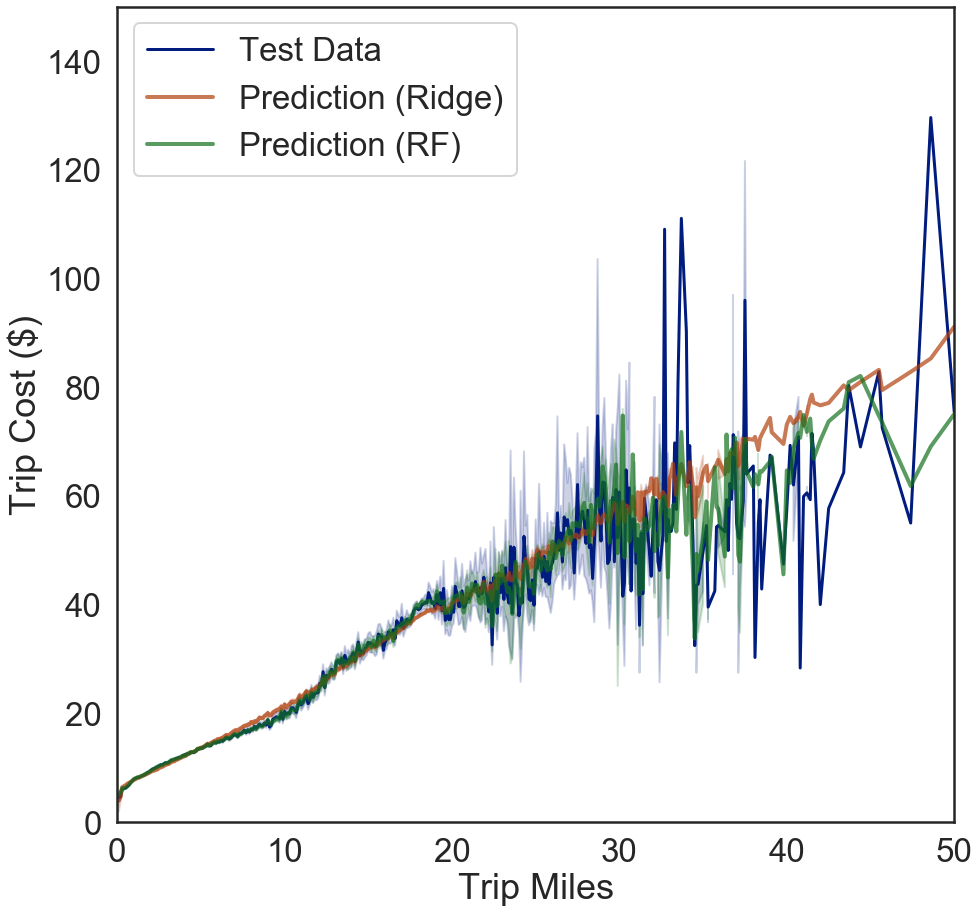

In [128]:
fig = plt.figure(figsize=(15,15))
sns.set(font_scale=2)

sns.set_style("white")
sns.set_context("poster", font_scale = 1.5, rc={"grid.linewidth": 5})

sns.set_palette('dark')
sns.lineplot(x=X_test1['Trip Miles'], y=y_test1,label ='Test Data', linewidth=3)
sns.lineplot(x=X_test1['Trip Miles'],alpha=0.7, y=y_pred_cost_ridge,label = 'Prediction (Ridge)', linewidth=4)
sns.lineplot(x=X_test1['Trip Miles'],alpha=0.7, y=y_pred_cost_RF,label = 'Prediction (RF)', linewidth=4)

plt.xlim(0,50)
plt.ylim(0,150)
plt.xlabel('Trip Miles')
plt.ylabel('Trip Cost ($)')

Text(0, 0.5, 'Trip Time (Mins)')

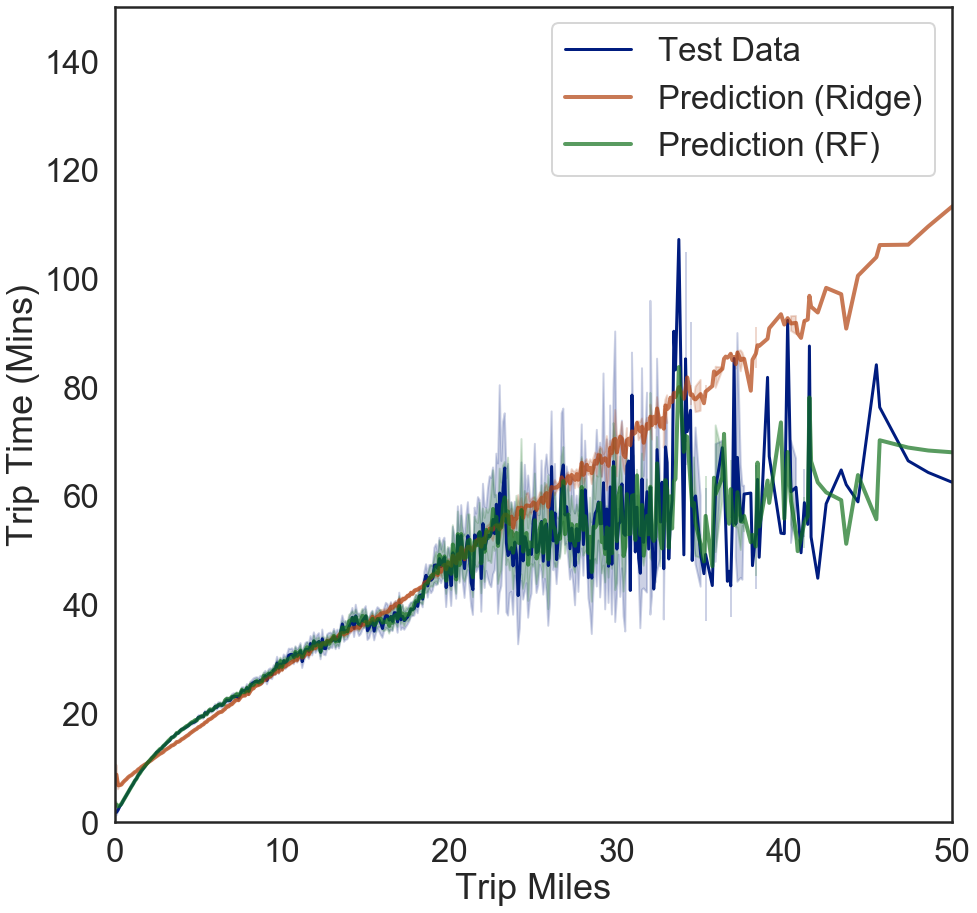

In [129]:
fig = plt.figure(figsize=(15,15))
sns.set(font_scale=2)

sns.set_style("white")
sns.set_context("poster", font_scale = 1.5, rc={"grid.linewidth": 5})

sns.set_palette('dark')
sns.lineplot(x=X_test2['Trip Miles'], y=y_test2,label ='Test Data', linewidth=3)
sns.lineplot(x=X_test2['Trip Miles'],alpha=0.7, y=y_pred_time_ridge,label = 'Prediction (Ridge)', linewidth=4)
sns.lineplot(x=X_test2['Trip Miles'],alpha=0.7, y=y_pred_time_RF,label = 'Prediction (RF)', linewidth=4)

plt.xlim(0,50)
plt.ylim(0,150)
plt.xlabel('Trip Miles')
plt.ylabel('Trip Time (Mins)')

Text(0, 0.5, 'Feature')

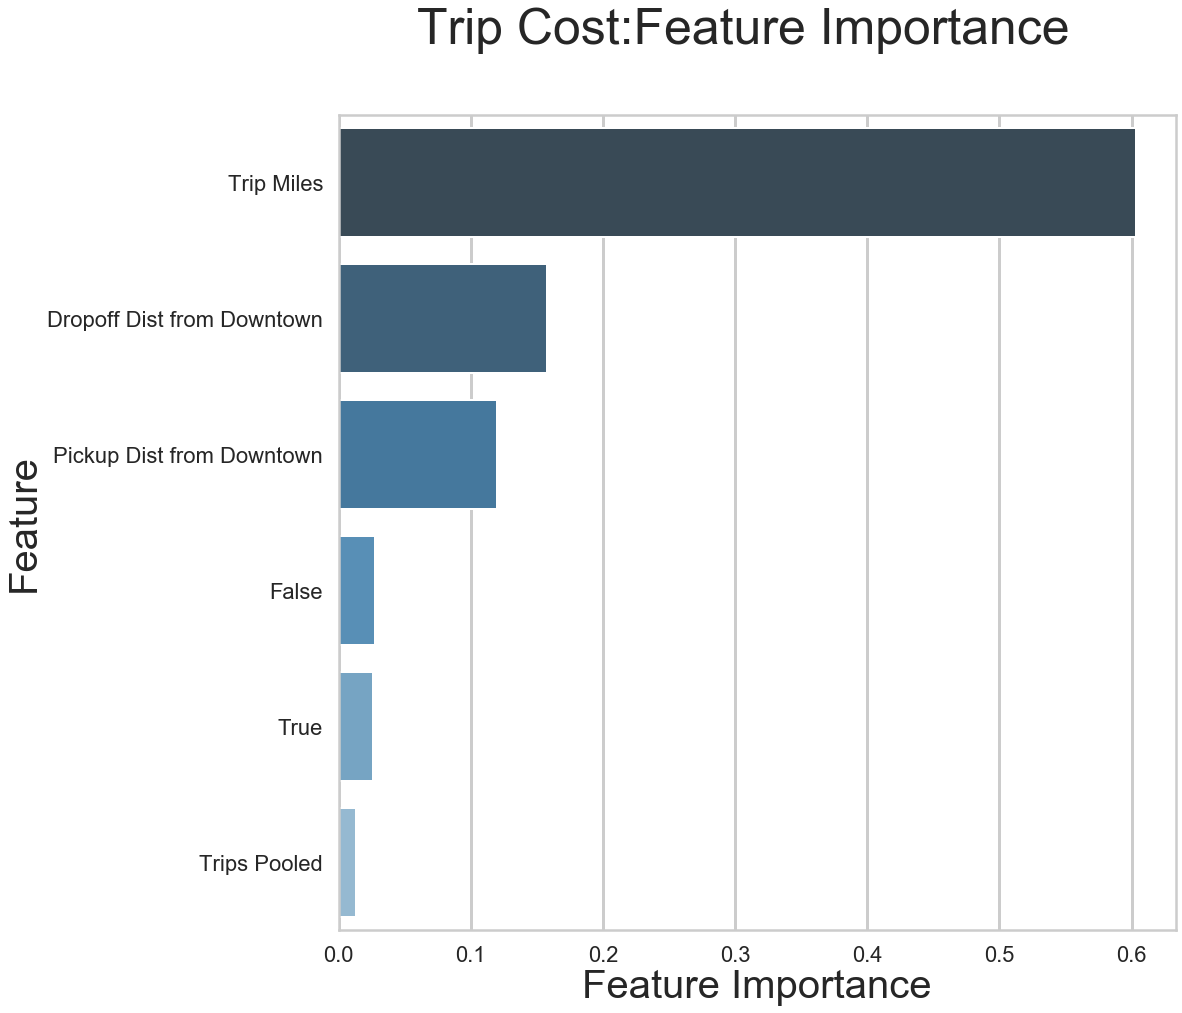

In [130]:
fig = plt.figure(figsize=(15,15))

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=2.5)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'white', "grid.linewidth": 3})

sns.barplot(x=(fi_cost_mat["Feature Importance"]), y="Feature", data=fi_cost_mat[0:6],  palette="Blues_d")

fig.suptitle('Trip Cost:Feature Importance', fontsize=50)
plt.xlabel('Feature Importance', fontsize=40)
plt.ylabel('Feature', fontsize=40)

Text(0, 0.5, 'Feature')

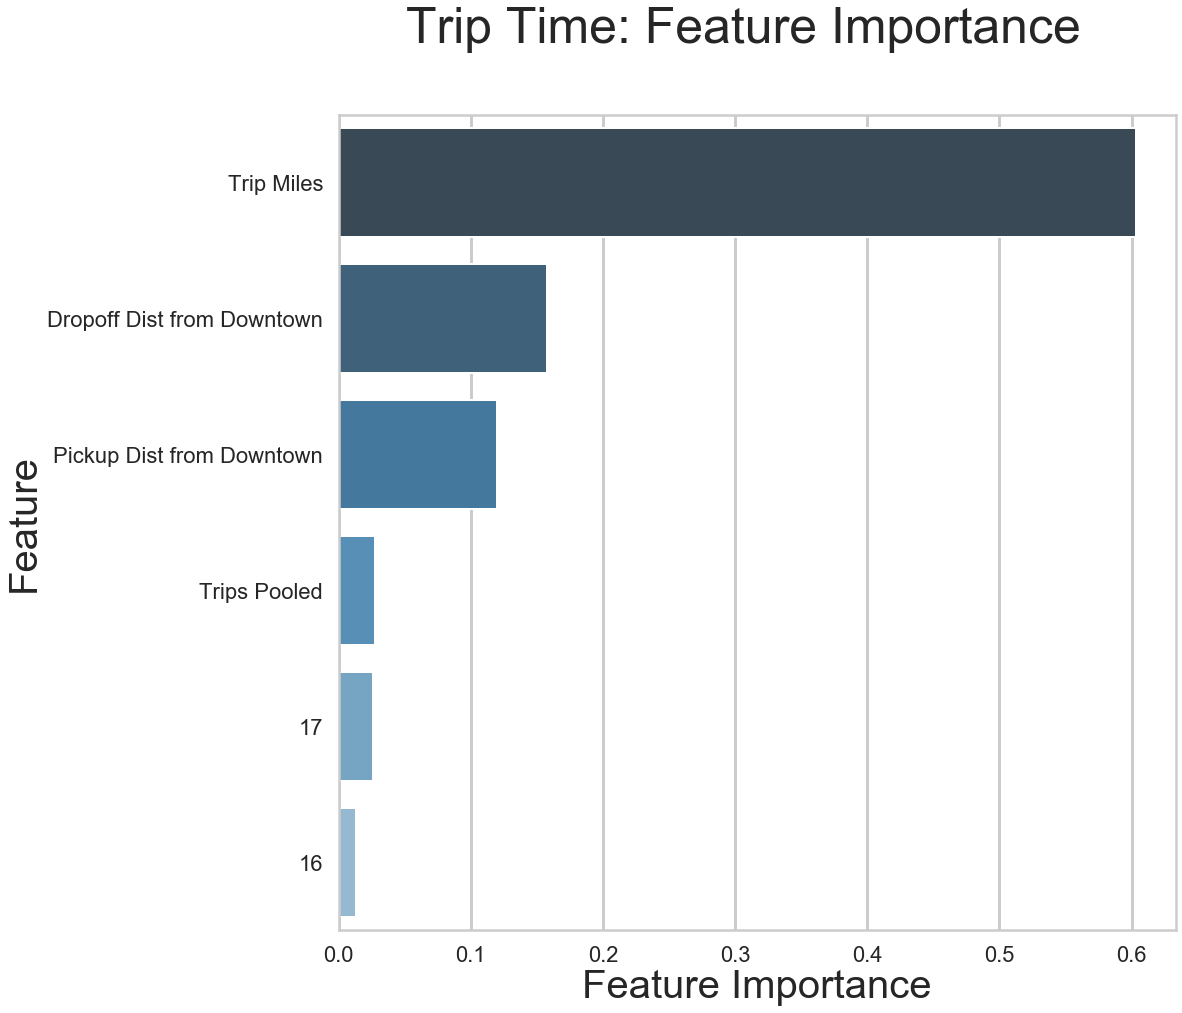

In [131]:
fig = plt.figure(figsize=(15,15))


sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=2.5)
sns.set_style("whitegrid")


sns.set_context("poster", rc={'grid.color': 'white', "grid.linewidth": 3})

sns.barplot(x=(fi_cost_mat["Feature Importance"]), y="Feature", data=fi_time_mat[0:6],  palette="Blues_d")

fig.suptitle('Trip Time: Feature Importance', fontsize=50)
plt.xlabel('Feature Importance', fontsize=40)
plt.ylabel('Feature', fontsize=40)
